# Importações

In [1]:
#!pip install scikit-learn pandas numpy matplotlib xgboost seaborn shap

In [2]:
import shap
import matplotlib.pyplot as plt

import pandas as pd 
import numpy as np  

# Pré-processamento e pipelines
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler

# Modelos de ML
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Validação e busca de hiperparâmetros
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform

# Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

c:\Users\hihi\Documents\GitHub\projeto-pisi3\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Carregando dataset

In [3]:
# Carregar o dataset
df = pd.read_csv('filmes_gabriel.csv')

# Dividindo os dados
- X_train, X_test, y_train, y_test

In [5]:
numerical_cols = df[['popularity', 'budget', 'runtime']].columns
categorical_col = ['original_language']
date_column = 'release_date'

X = df.drop(columns=['vote_average'])
y = df['vote_average']

# Dividindo o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=87)

# Transformadores

### Colunas: Generos Cinematográficos e Produtora
Aplicando MultiLabelBinarize com limites de 12 e 10, respectivamente

In [6]:
def process_multilabel_column(train_series, test_series, sep='-', top_n=20, outros=True, prefix=''):
    # Extrair top N do treino
    exploded = train_series.str.split(sep).explode().str.strip()
    top = exploded.value_counts().nlargest(top_n).index

    def filter_top(vals):
        vals = [v.strip() for v in vals.split(sep)]
        if outros:
            return [v if v in top else 'Outros' for v in vals]
        else:
            return [v for v in vals if v in top]

    # Aplicar transformação
    train_processed = train_series.apply(filter_top)
    test_processed = test_series.apply(filter_top)

    mlb = MultiLabelBinarizer()
    train_encoded = pd.DataFrame(
        mlb.fit_transform(train_processed),
        columns=[f'{prefix}_{cls}' for cls in mlb.classes_],
        index=train_series.index
    )
    test_encoded = pd.DataFrame(
        mlb.transform(test_processed),
        columns=[f'{prefix}_{cls}' for cls in mlb.classes_],
        index=test_series.index
    )

    return train_encoded, test_encoded


### Generos cinematográficos

In [7]:
teste = X_train['genres'].apply(lambda x: x.split('-')).copy()
teste = teste.explode().reset_index(drop=True)
genre_counts = teste.value_counts() # Apply value_counts directly to the Series
print(genre_counts)
print(len(genre_counts))

genres
Drama              3878
Comedy             2841
Thriller           2261
Action             2163
Romance            1426
Adventure          1396
Crime              1323
Horror             1316
Science Fiction     996
Fantasy             793
Family              770
Mystery             743
History             439
Animation           412
War                 342
Music               263
Western             141
Documentary         101
TV Movie             65
Name: count, dtype: int64
19


In [8]:
genres_train, genres_test = process_multilabel_column(
    X_train['genres'], X_test['genres'], sep='-', top_n=12, outros=True, prefix='genre'
)

# Substituir a coluna original
X_train = X_train.drop(columns='genres').join(genres_train)
X_test = X_test.drop(columns='genres').join(genres_test)

### Produtoras

In [9]:
teste = X_train['production_companies'].apply(lambda x: x.split('-')).copy()
teste = teste.explode().reset_index(drop=True)
production_counts = teste.value_counts() # Apply value_counts directly to the Series
print(production_counts)
print(len(production_counts))

production_companies
Universal Pictures       516
Warner Bros. Pictures    500
20th Century Fox         376
Columbia Pictures        371
Paramount                371
                        ... 
Cenoura Filmes             1
Factoria Corman            1
Double R Productions       1
Movie Machine              1
Dry County Films           1
Name: count, Length: 9944, dtype: int64
9944


In [10]:
production_train, production_test = process_multilabel_column(
    X_train['production_companies'], X_test['production_companies'], sep='-', top_n=8, outros=True, prefix='production'
)

# Substituir a coluna original
X_train = X_train.drop(columns='production_companies').join(production_train)
X_test = X_test.drop(columns='production_companies').join(production_test)

## Colunas de data
Transformer: Data para ano/mês

In [11]:
class DateFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, date_column):
        self.date_column = date_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.date_column] = pd.to_datetime(X[self.date_column], errors='coerce')
        X['year'] = X[self.date_column].dt.year
        X['month'] = X[self.date_column].dt.month
        return X.drop(columns=[self.date_column])

## Outliers
- CapTransformer: Cap
- LogCapTransformer: Cap + Log
- Winsorizer

In [12]:
class CapTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.bounds_ = {}

    def fit(self, X, y=None):
        X = X.copy()
        for col in self.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            self.bounds_[col] = (lower, upper)
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            lower, upper = self.bounds_[col]
            X[col] = X[col].clip(lower, upper)
        return X


In [13]:
class LogCapTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.bounds_ = {}

    def fit(self, X, y=None):
        X = X.copy()
        for col in self.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            self.bounds_[col] = (lower, upper)
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            lower, upper = self.bounds_[col]
            X[col] = X[col].clip(lower, upper)
            X[col] = np.log1p(X[col])
        return X

In [14]:
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, lower_percentile=0.05, upper_percentile=0.95):
        self.columns = columns
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile
        self.bounds_ = {}

    def fit(self, X, y=None):
        X = X.copy()
        for c in self.columns:
            low = X[c].quantile(self.lower_percentile)
            high = X[c].quantile(self.upper_percentile)
            self.bounds_[c] = (low, high)
        return self

    def transform(self, X):
        X = X.copy()
        for c, (low, high) in self.bounds_.items():
            X[c] = X[c].clip(low, high)
        return X


## Agrupar categorias raras
- original_language

In [15]:
class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, column, top_n=10, other_label='Other'):
        self.column = column
        self.top_n = top_n
        self.other_label = other_label

    def fit(self, X, y=None):
        # armazena os top_n valores da coluna no treino
        vc = X[self.column].value_counts()
        self.top_ = vc.nlargest(self.top_n).index.tolist()
        return self

    def transform(self, X):
        X = X.copy()
        X[self.column] = X[self.column].where(
            X[self.column].isin(self.top_),
            other=self.other_label
        )
        return X


# Treinamento
- Modelo XGBRegressor
- Modelo SVR
- Modelo RandomForest

### Definindo Kf

In [16]:
# Definindo o KFold para o cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=87)

### XGBRegressor

In [17]:
# Cap de outliers + padronização
num_pipeline = Pipeline([
    ('cap', LogCapTransformer(columns=numerical_cols)),
    ('scale', StandardScaler())
])

num_pipeline2 = Pipeline([
    ('winsor', Winsorizer(columns=numerical_cols,
                          lower_percentile=0.01,
                          upper_percentile=0.99)),
    ('robust_scale', RobustScaler())
])

# OneHot para variáveis categóricas
cat_pipeline = Pipeline([
    ('rare', RareCategoryGrouper(column='original_language', top_n=10, other_label='Other')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pré-processador geral
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_col)
], remainder='passthrough')  # passa as colunas de ano/mês e binarizadas


# Pipeline Completo
pipeline = Pipeline([
    ('date', DateFeatureExtractor(date_column=date_column)),  # extrai year e month
    ('preprocess', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))
])

# RandomizedSearch
param_dist = {
    'regressor__n_estimators': randint(100, 300),
    'regressor__max_depth': randint(3, 10),
    'regressor__learning_rate': uniform(0.01, 0.3),
    'regressor__subsample': uniform(0.7, 0.3),
    'regressor__colsample_bytree': uniform(0.7, 0.3),
}

kf = KFold(n_splits=5, shuffle=True, random_state=87)

XGBRegressor_rand = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,
    cv=kf,
    scoring='r2',
    random_state=87,
    verbose=2,
    n_jobs=-1
)

# Treinamento e resultado
XGBRegressor_rand.fit(X_train, y_train)

print("Melhores parâmetros:", XGBRegressor_rand.best_params_)
print("Melhor R² (validação cruzada):", XGBRegressor_rand.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Melhores parâmetros: {'regressor__colsample_bytree': np.float64(0.8696231377727208), 'regressor__learning_rate': np.float64(0.05992056035524427), 'regressor__max_depth': 5, 'regressor__n_estimators': 241, 'regressor__subsample': np.float64(0.8173221947525602)}
Melhor R² (validação cruzada): 0.48819693290208566


### SVR

In [18]:
# Pipeline para numéricas com cap e padronização
num_pipeline = Pipeline([
    ('cap', LogCapTransformer(columns=numerical_cols)),
    ('scale', StandardScaler())
])

num_pipeline2 = Pipeline([
    ('winsor', Winsorizer(columns=numerical_cols,
                          lower_percentile=0.01,
                          upper_percentile=0.99)),
    ('robust_scale', RobustScaler())
])

# Pipeline para categóricas com OneHot
cat_pipeline = Pipeline([
    ('rare', RareCategoryGrouper(column='original_language', top_n=10, other_label='Other')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# ColumnTransformer para combinar tudo
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_col)
], remainder='passthrough')  # mantém as colunas como 'year', 'month', e as multilabel binarizadas


pipeline = Pipeline([
    ('date', DateFeatureExtractor(date_column=date_column)),  # extrai 'year' e 'month'
    ('preprocess', preprocessor),
    ('regressor', SVR())
])

param_dist = {
    'regressor__kernel': ['rbf', 'linear'],
    'regressor__C': loguniform(1e-2, 1e2),
    'regressor__epsilon': uniform(0.01, 0.3),
    'regressor__gamma': ['scale', 'auto']
}


svm_rand = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=15,  
    cv=kf,
    scoring='r2',
    random_state=87,
    verbose=2,
    n_jobs=-1
)

svm_rand.fit(X_train, y_train)

print("Melhores parâmetros:", svm_rand.best_params_)
print("Melhor R² (validação cruzada):", svm_rand.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Melhores parâmetros: {'regressor__C': np.float64(2.938694691454592), 'regressor__epsilon': np.float64(0.21005810752620088), 'regressor__gamma': 'auto', 'regressor__kernel': 'rbf'}
Melhor R² (validação cruzada): 0.44964292669394385


### RandomForest

In [ ]:
# 1) Cap + StandardScaler (ou Winsor + RobustScaler, escolha qual usar)
num_pipeline = Pipeline([
    ('cap', LogCapTransformer(columns=numerical_cols)),
    ('scale', StandardScaler())
])

# 2) Categóricas com “rare + onehot”
cat_pipeline = Pipeline([
    ('rare', RareCategoryGrouper(column='original_language', top_n=10, other_label='Other')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 3) Combina tudo
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_col)
], remainder='passthrough')


# --- Pipeline final com RandomForest ---
pipeline_rf = Pipeline([
    ('date', DateFeatureExtractor(date_column=date_column)),
    ('preprocess', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
])


# --- Espaço de busca para RandomizedSearchCV ---
param_dist_rf = {
    'regressor__n_estimators': randint(100, 500),
    'regressor__max_depth': randint(3, 20),
    'regressor__min_samples_split': randint(2, 10),
    'regressor__min_samples_leaf': randint(1, 10),
    'regressor__max_features': ['sqrt', 'log2', None]
}

rf_rand = RandomizedSearchCV(
    estimator=pipeline_rf,
    param_distributions=param_dist_rf,
    n_iter=30,
    cv=kf,
    scoring='r2',
    error_score='raise',     
    random_state=87,
    verbose=2,
    n_jobs=-1
)

# --- Treino e outputs ---
rf_rand.fit(X_train, y_train)

print("Melhores parâmetros RF:", rf_rand.best_params_)
print("Melhor R² (CV) RF:", rf_rand.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Melhores parâmetros RF: {'regressor__max_depth': 14, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 430}
Melhor R² (CV) RF: 0.4629751716571979


# Avaliação dos modelos

In [20]:
def evaluate_model(model_name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        'Modelo': model_name,
        'R²': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MedAE': median_absolute_error(y_test, y_pred)
    }


In [21]:
results = []

results.append(evaluate_model("XGBRegressor", XGBRegressor_rand.best_estimator_, X_test, y_test))
results.append(evaluate_model("SVR", svm_rand.best_estimator_, X_test, y_test))
results.append(evaluate_model("RandomForestRegressor", rf_rand.best_estimator_, X_test, y_test))

results_df = pd.DataFrame(results)
print(results_df)

                  Modelo        R²       MAE      RMSE     MedAE
0           XGBRegressor  0.506396  0.485179  0.641401  0.387282
1                    SVR  0.455985  0.507053  0.673357  0.396875
2  RandomForestRegressor  0.475739  0.502093  0.661019  0.415403


# Testes

In [26]:
# Erro de importação do SHAP com o numpy 

#!pip uninstall numpy
#!pip install numpy==1.22.4 

                    feature  importance
21             genre_Horror    0.116077
18              genre_Drama    0.113681
23             genre_Outros    0.089520
5      original_language_en    0.069483
2                   runtime    0.068444
14             genre_Action    0.045479
0                popularity    0.042071
3   original_language_Other    0.036874
25    genre_Science Fiction    0.034030
36                     year    0.033834


 99%|===================| 8385/8472 [00:58<00:00]        

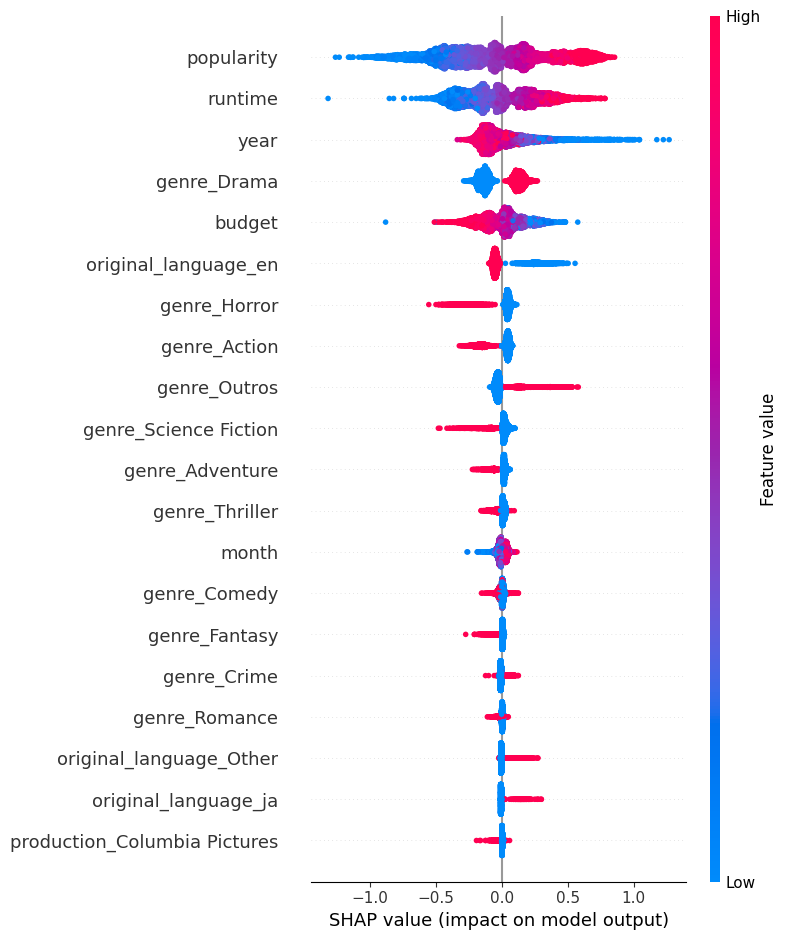

In [27]:
import shap

# Extrair o modelo XGBRegressor treinado do pipeline
xgb_model = XGBRegressor_rand.best_estimator_.named_steps['regressor']

# Extrair as features após o processamento
# Precisamos transformar X_train para obter as features corretas
X_train_transformed = XGBRegressor_rand.best_estimator_.named_steps['preprocess'].transform(
    XGBRegressor_rand.best_estimator_.named_steps['date'].transform(X_train)
)

# Obter os nomes das features após o ColumnTransformer
feature_names = []
# num_pipeline features
feature_names += list(numerical_cols)
# cat_pipeline features
cat_features = X_train[categorical_col[0]].unique()
cat_feature_names = XGBRegressor_rand.best_estimator_.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_col)
feature_names += list(cat_feature_names)
# remainder (multilabels, year, month)
remainder = [col for col in X_train.columns if col not in numerical_cols and col not in categorical_col and col != date_column]
feature_names += remainder + ['year', 'month']

# Feature importances do XGBoost
importances = xgb_model.feature_importances_

# Exibir as 10 features mais importantes
importances_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
print(importances_df.sort_values('importance', ascending=False).head(10))

# SHAP
explainer = shap.Explainer(xgb_model, X_train_transformed, feature_names=feature_names)
shap_values = explainer(X_train_transformed)

# Resumo SHAP
shap.summary_plot(shap_values, features=X_train_transformed, feature_names=feature_names)

In [28]:
pd.set_option('display.max_rows', None)
display(importances_df.sort_values('importance', ascending=False))
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

,feature,importance
21,genre_Horror,0.116077
18,genre_Drama,0.113681
23,genre_Outros,0.089520
5,original_language_en,0.069483
2,runtime,0.068444
14,genre_Action,0.045479
0,popularity,0.042071
3,original_language_Other,0.036874
25,genre_Science Fiction,0.034030
36,year,0.033834
